# Power Budget

In [1]:
import pandas as pd

# Load the CSV files
power_requirements = pd.read_csv("power_requirements.csv")
power_modes = pd.read_csv("power_modes.csv")

# Create a lookup dictionary: {(Subsystem, Mode): Power}
power_lookup = {
    (row['Subsystem'].strip(), row['Subsys Mode'].strip()): row['Power Consumption (W)']
    for _, row in power_requirements.iterrows()
}

# Process each mode and print results
for idx, row in power_modes.iterrows():
    mode_name = row.iloc[0]
    print(f"\n=== {mode_name} ===")
    total_power = 0

    for subsystem, status in row.iloc[1:].items():
        key = (subsystem.strip(), str(status).strip())
        power = power_lookup.get(key, 0)
        print(f"{subsystem.strip()}\t{power}")
        total_power += power

    print(f"\nTotal {total_power:.2f} W")



=== Mode 1 ===
EPSA1 & EPSA2	1.85
EPSA2 Heaters	8.72
EPSA3	1.0
OBC	5.4
COMMS S-BAND	0.0
COMMS x-BAND	0
ADCS	0.92
PDPU	0.0
ASTROPAYLOAD	0.0
ISL	0.0

Total 17.89 W

=== Mode 2 ===
EPSA1 & EPSA2	1.85
EPSA2 Heaters	8.72
EPSA3	0.0
OBC	5.86
COMMS S-BAND	1.78
COMMS x-BAND	0
ADCS	7.51
PDPU	0.0
ASTROPAYLOAD	0.0
ISL	0.0

Total 25.72 W


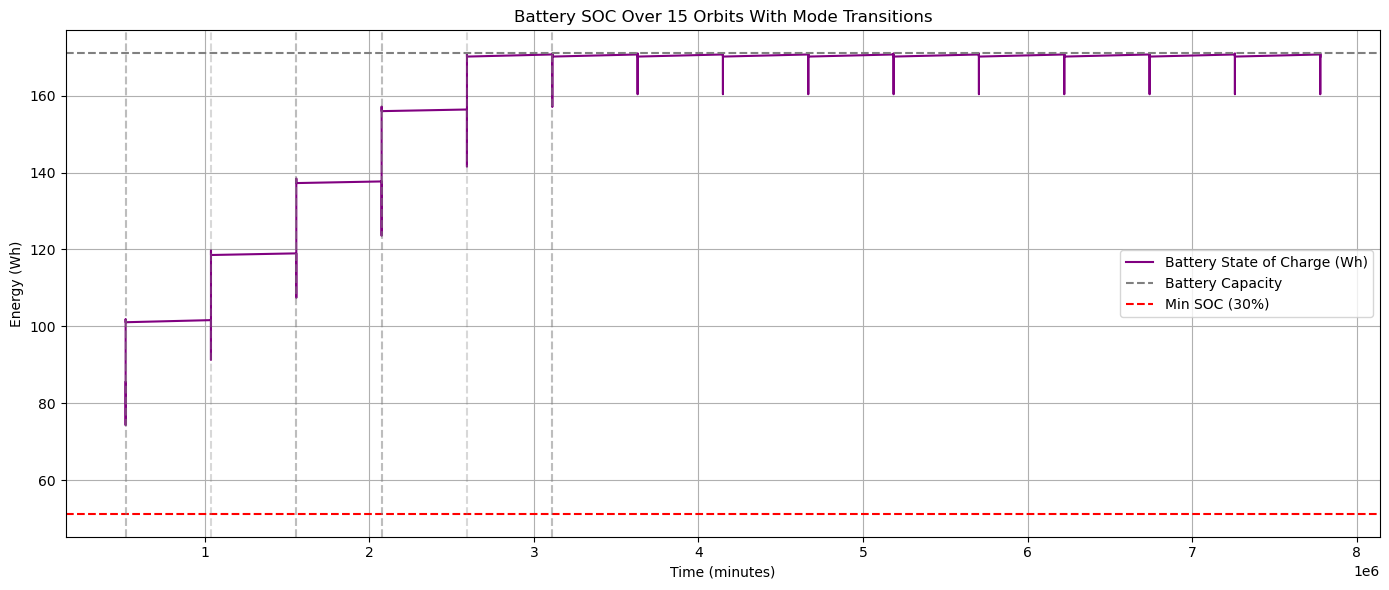

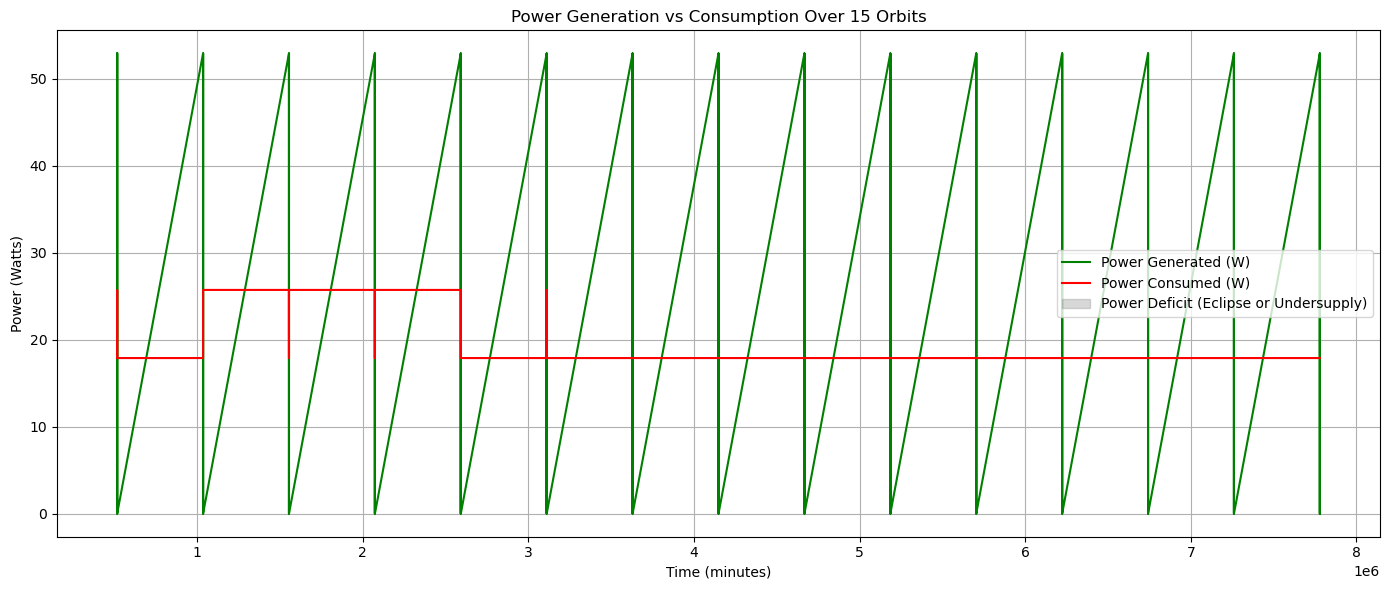

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
power_generated = pd.read_csv("power_generated_orbit.csv")
power_modes = pd.read_csv("power_modes.csv")
power_requirements = pd.read_csv("power_requirements.csv")

# Build power lookup dictionary
power_lookup = {
    (row['Subsystem'].strip(), row['Subsys Mode'].strip()): row['Power Consumption (W)']
    for _, row in power_requirements.iterrows()
}

# Clean and process solar power data
power_generated["POWER_GENERATION_WATTS"] = pd.to_numeric(power_generated["POWER_GENERATION_WATTS"], errors='coerce')
power_generated["ELAPSED_TIME_SEC"] = pd.to_numeric(power_generated["ELAPSED_TIME_SEC"], errors='coerce')
power_generated.dropna(subset=["POWER_GENERATION_WATTS", "ELAPSED_TIME_SEC"], inplace=True)
time_sec = power_generated["ELAPSED_TIME_SEC"].to_numpy()
power_generated_w = power_generated["POWER_GENERATION_WATTS"].to_numpy()

# Extend solar profile for 15 orbits
orbits = 15
orbit_duration_sec = time_sec[-1]
full_time_sec = np.concatenate([time_sec + i * orbit_duration_sec for i in range(orbits)])
full_power_generated_w = np.tile(power_generated_w, orbits)
dt = np.mean(np.diff(time_sec))

# Mode schedule (edit as needed)
mode_schedule = [("Mode 1", 30), ("Mode 2", 60), ("Mode 1", 30)] * 5

# Construct power profile from schedule
mode_power_profile = []
mode_time_profile = []
for mode_name, duration_min in mode_schedule:
    mode_row = power_modes[power_modes.iloc[:, 0] == mode_name].iloc[0]
    total_power = 0
    for subsystem, status in mode_row.iloc[1:].items():
        key = (subsystem.strip(), str(status).strip())
        total_power += power_lookup.get(key, 0)
    duration_sec = duration_min * 60
    n_samples = int(duration_sec / dt)
    mode_power_profile.extend([total_power] * n_samples)
    mode_time_profile.extend([mode_name] * n_samples)

# Pad or trim profile to match generation length
mode_power_profile = mode_power_profile[:len(full_power_generated_w)]
while len(mode_power_profile) < len(full_power_generated_w):
    mode_power_profile.append(mode_power_profile[-1])

# Battery parameters
battery_capacity_Wh = 171
battery_capacity_J = battery_capacity_Wh * 3600
initial_soc = 0.5
battery_energy = [battery_capacity_J * initial_soc]

# Battery simulation
for i in range(1, len(full_time_sec)):
    net_power = full_power_generated_w[i] - mode_power_profile[i]
    new_energy = battery_energy[-1] + net_power * dt
    new_energy = max(0, min(new_energy, battery_capacity_J))
    battery_energy.append(new_energy)
battery_soc_wh = np.array(battery_energy) / 3600
time_min = full_time_sec / 60

# Plot battery SOC
plt.figure(figsize=(14, 6))
plt.plot(time_min, battery_soc_wh, label="Battery State of Charge (Wh)", color='purple')
plt.axhline(battery_capacity_Wh, linestyle='--', color='gray', label="Battery Capacity")
plt.axhline(battery_capacity_Wh * 0.3, linestyle='--', color='red', label="Min SOC (30%)")
prev_mode = mode_time_profile[0]
for i in range(1, len(mode_time_profile)):
    if mode_time_profile[i] != prev_mode:
        plt.axvline(full_time_sec[i] / 60, color='gray', linestyle='--', alpha=0.3)
        prev_mode = mode_time_profile[i]
plt.xlabel("Time (minutes)")
plt.ylabel("Energy (Wh)")
plt.title("Battery SOC Over 15 Orbits With Mode Transitions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot power generated vs consumed
mode_power_profile = np.array(mode_power_profile[:len(full_power_generated_w)])
full_power_generated_w = np.array(full_power_generated_w)
plt.figure(figsize=(14, 6))
plt.plot(time_min, full_power_generated_w, label="Power Generated (W)", color='green')
plt.plot(time_min, mode_power_profile, label="Power Consumed (W)", color='red')
plt.fill_between(time_min, 0, full_power_generated_w, where=(full_power_generated_w < mode_power_profile),
                 color='gray', alpha=0.3, label="Power Deficit (Eclipse or Undersupply)")
plt.xlabel("Time (minutes)")
plt.ylabel("Power (Watts)")
plt.title("Power Generation vs Consumption Over 15 Orbits")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\WilliamAvison\AppData\Local\Temp\ipykernel_8788\3341244794.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ELAPSED_TIME_SEC"] -= df["ELAPSED_TIME_SEC"].iloc[0]


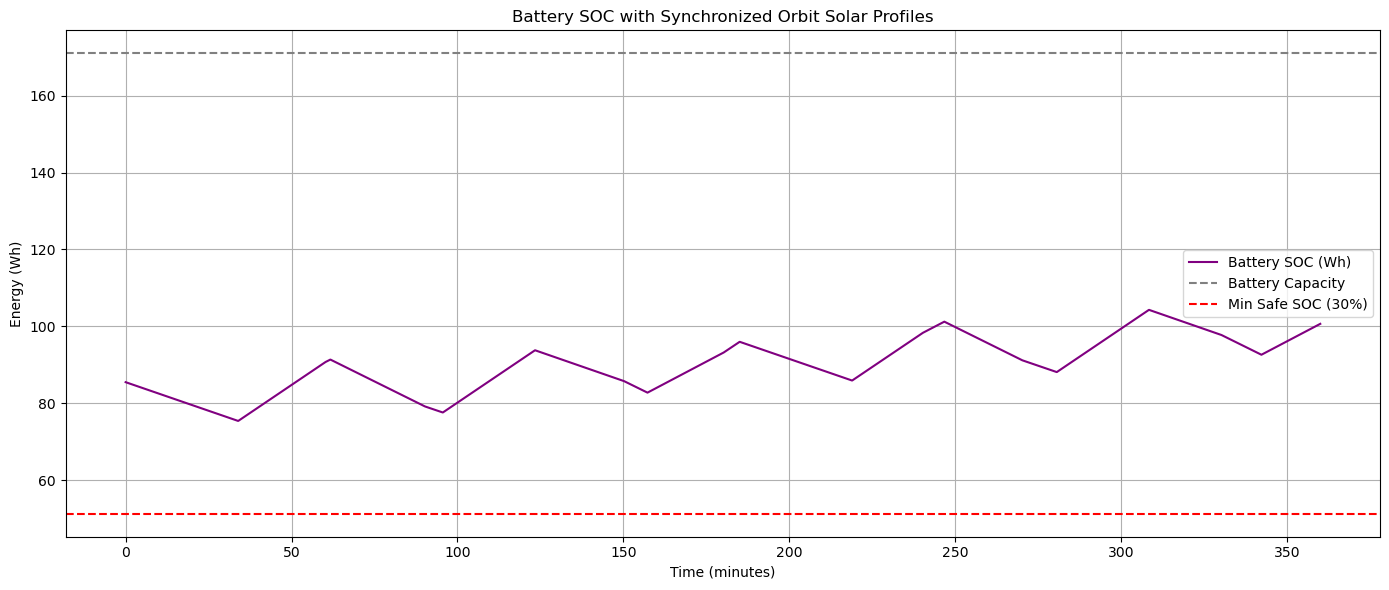

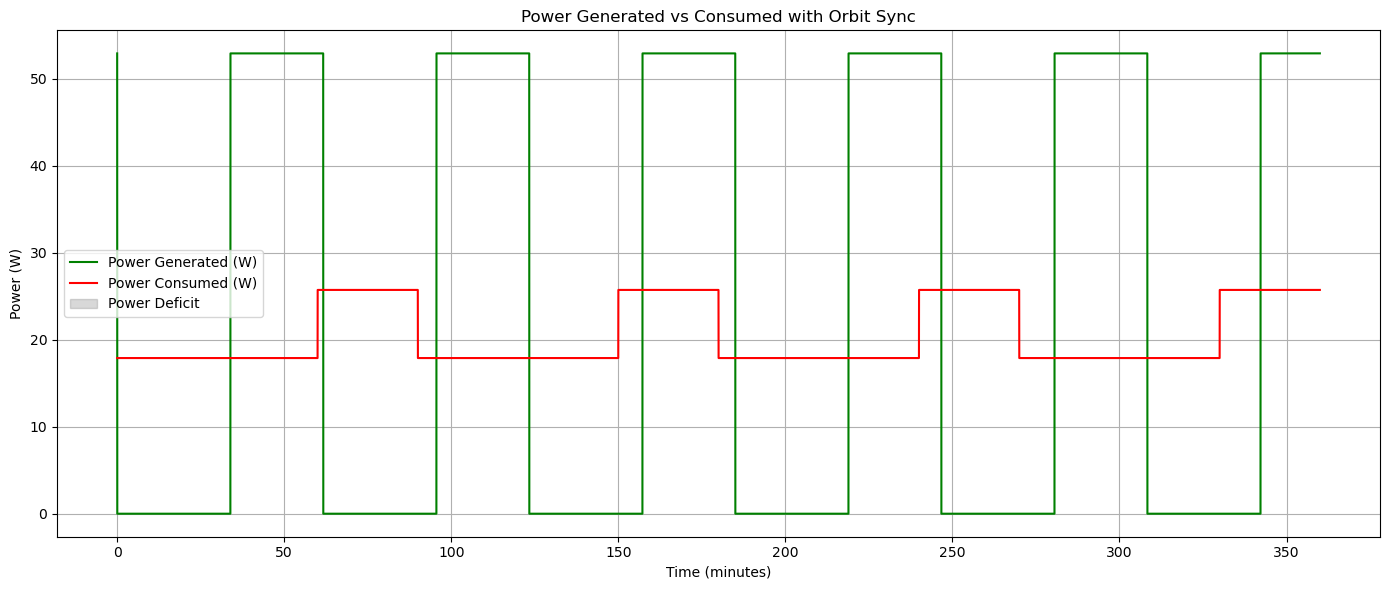

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV files
power_generated_sun_nad = pd.read_csv("power_generated_sun_nad.csv")
power_generated_vel_sun = pd.read_csv("power_generated_vel_sun.csv")
power_modes = pd.read_csv("power_modes.csv")
power_requirements = pd.read_csv("power_requirements.csv")
mode_schedule_df = pd.read_csv("mode_schedule.csv")

# Constants
ORBIT_DURATION_LIMIT = 3700  # seconds, average orbit duration
dt = 1  # second time step assumed for interpolation

# Trim and normalize solar profiles to 0–3700 seconds
def preprocess_solar(df):
    df["POWER_GENERATION_WATTS"] = pd.to_numeric(df["POWER_GENERATION_WATTS"], errors='coerce')
    df["ELAPSED_TIME_SEC"] = pd.to_numeric(df["ELAPSED_TIME_SEC"], errors='coerce')
    df.dropna(subset=["POWER_GENERATION_WATTS", "ELAPSED_TIME_SEC"], inplace=True)
    df = df[df["ELAPSED_TIME_SEC"] - df["ELAPSED_TIME_SEC"].iloc[0] <= ORBIT_DURATION_LIMIT]
    df["ELAPSED_TIME_SEC"] -= df["ELAPSED_TIME_SEC"].iloc[0]
    return df.reset_index(drop=True)

sun_nad = preprocess_solar(power_generated_sun_nad)
vel_sun = preprocess_solar(power_generated_vel_sun)

# Create shared orbit time base and interpolate profiles
orbit_time_base = np.arange(0, ORBIT_DURATION_LIMIT + dt, dt)
interp_sun_nad = np.interp(orbit_time_base, sun_nad["ELAPSED_TIME_SEC"], sun_nad["POWER_GENERATION_WATTS"])
interp_vel_sun = np.interp(orbit_time_base, vel_sun["ELAPSED_TIME_SEC"], vel_sun["POWER_GENERATION_WATTS"])

# Lookup table of power generation profiles
solar_profile_map = {
    "power_generated_sun_nad": interp_sun_nad,
    "power_generated_vel_sun": interp_vel_sun
}

# Power consumption lookup
power_lookup = {
    (row['Subsystem'].strip(), row['Subsys Mode'].strip()): row['Power Consumption (W)']
    for _, row in power_requirements.iterrows()
}

# Generate full time series from mode_schedule
full_time_sec = []
full_power_generated_w = []
mode_power_profile = []
mode_labels = []

orbit_cursor = 0
for _, row in mode_schedule_df.iterrows():
    mode_name = row["mode"]
    duration_min = int(row["time in mode"])
    profile_key = row["power generated"].strip()

    profile = solar_profile_map[profile_key]
    samples_needed = duration_min * 60
    for i in range(samples_needed):
        orbit_time = int(orbit_cursor % ORBIT_DURATION_LIMIT)
        full_power_generated_w.append(profile[orbit_time])
        full_time_sec.append(orbit_cursor)
        mode_labels.append(mode_name)
        orbit_cursor += 1

    # Get power usage for this mode
    mode_row = power_modes[power_modes.iloc[:, 0] == mode_name].iloc[0]
    total_power = 0
    for subsystem, status in mode_row.iloc[1:].items():
        total_power += power_lookup.get((subsystem.strip(), str(status).strip()), 0)
    mode_power_profile.extend([total_power] * samples_needed)

# Battery parameters
battery_capacity_Wh = 171
battery_capacity_J = battery_capacity_Wh * 3600
initial_soc = 0.5
battery_energy = [battery_capacity_J * initial_soc]

# Battery simulation
for i in range(1, len(full_time_sec)):
    net_power = full_power_generated_w[i] - mode_power_profile[i]
    battery_energy.append(np.clip(battery_energy[-1] + net_power * dt, 0, battery_capacity_J))
battery_soc_wh = np.array(battery_energy) / 3600
time_min = np.array(full_time_sec) / 60

# Plot SOC
plt.figure(figsize=(14, 6))
plt.plot(time_min, battery_soc_wh, label="Battery SOC (Wh)", color='purple')
plt.axhline(battery_capacity_Wh, linestyle='--', color='gray', label="Battery Capacity")
plt.axhline(battery_capacity_Wh * 0.3, linestyle='--', color='red', label="Min Safe SOC (30%)")
plt.xlabel("Time (minutes)")
plt.ylabel("Energy (Wh)")
plt.title("Battery SOC with Synchronized Orbit Solar Profiles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Power Generated vs Consumed
plt.figure(figsize=(14, 6))
plt.plot(time_min, full_power_generated_w, label="Power Generated (W)", color='green')
plt.plot(time_min, mode_power_profile, label="Power Consumed (W)", color='red')
plt.fill_between(time_min, 0, full_power_generated_w, where=(np.array(full_power_generated_w) < np.array(mode_power_profile)),
                 color='gray', alpha=0.3, label="Power Deficit")
plt.xlabel("Time (minutes)")
plt.ylabel("Power (W)")
plt.title("Power Generated vs Consumed with Orbit Sync")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
